# Coastal Urbanization


<div class="alert alert-block alert-danger">
<b>Problem:</b> There is an issue with this notebook/class where dask seems to start failing before the displayed memory reaches the instance memory limit. I have tried changing some of the dask settings, persisting vs computing, chunks size etc. I would like the intermdiate arrays for other parts of the analysis. The steps seem to work when done manually outside of the class. Hope its a simple error and easy to solve. Thanks!
</div>

In [14]:
import datacube
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from datacube.utils.cog import write_cog
import folium.plugins
import folium
from odc.algo import xr_geomedian
from odc.ui import with_ui_cbk
sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_datahandling import mostcommon_crs
from deafrica_bandindices import calculate_indices
from deafrica_coastaltools import tidal_tag
from deafrica_spatialtools import subpixel_contours
from deafrica_spatialtools import interpolate_2d
from deafrica_spatialtools import contours_to_arrays
from deafrica_plotting import display_map
from deafrica_plotting import map_shapefile
from deafrica_plotting import rgb
from deafrica_dask import create_local_dask_cluster
import rioxarray
import rasterio
import rasterio.windows as windows
from rasterio.enums import Resampling
from skimage.morphology import disk, dilation

/env/lib/python3.6/site-packages/cligj/__init__.py:17: FutureWarning: cligj 1.0.0 will require Python >= 3.7
  warn("cligj 1.0.0 will require Python >= 3.7", FutureWarning)


In [5]:
dc = datacube.Datacube(app='coastal_urbanization')

In [5]:
cluster = create_local_dask_cluster(n_workers=2, spare_mem= '1gb')

Client Scheduler: tcp://127.0.0.1:46243 Dashboard: /user/brianbterry/proxy/8787/status,Cluster Workers: 2 Cores: 2 Memory: 15.11 GB


In [6]:
from typing import NamedTuple
#possible full analysis class?
#TODO upgrade to using named tuples but would have to change parameters
class Location(NamedTuple):
    name: str
    lat: float
    lon: float
    area: float = .10
        
stl = Location(
    name = 'stlouis',
    lat = 16.01366,
    lon = -16.49195
)

    
saly = Location(
    name = 'saly',
    lat = 14.43,
    lon = -17.00
)

corniche = Location(
    name = 'corniche',
    lat = 14.72618,
    lon = -17.50387 
)

locations =  [saly, corniche, stl]

In [7]:
class Analysis:
    
    def __init__(self, loc: Location, dc: datacube):
        self.datacube = dc
        self.name= loc.name
        self.location = (loc.lat, loc.lon) #TODO change name to "coordinates" or Location class
        self.latitude = self.lat = loc.lat
        self.longitude = self.lon = loc.lon
        self.create_extent()
        self.create_ds()
        self.create_mosaic()
        self.create_indices()
        self.path =  f'./urbanisation/{self.name}'
        self.map = display_map(**self.extent)
    
    def create_extent(self, area = .10):
        #transforms a location into area for loading
        buffer= area/2
        lat_range = (self.lat-buffer, self.lat+buffer)
        lon_range = (self.lon-buffer, self.lon+buffer)
        self.extent = { 'y': lat_range, 'x': lon_range}
        self.upper_left = self.ul = [self.extent['y'][0], self.extent['x'][0]]
        self.upper_right = self.ur = [self.extent['y'][0], self.extent['x'][1]]
        self.lower_right = self.lr = [self.extent['y'][1], self.extent['x'][1]]
        self.lower_left = self.ll = [self.extent['y'][1], self.extent['x'][0]]
    
    def create_ds(self, query = None):

        #Defaul query
        if query == None:

            time_range = ('2000', '2018')

            products=['s2_l2a']

                    #[  'ls5_usgs_sr_scene', 
                    #   'ls7_usgs_sr_scene', 
                    #   'ls8_usgs_sr_scene']

            bands = ['red',
                     'green',
                     'blue', 
                     'nir',
                     'swir_1',
                     'swir_2']

            query = {
                'time': time_range,
                'products': products,
                'measurements': bands,
                'resolution': (-10, 10),
                'output_crs': 'EPSG:6933',
                'min_gooddata': 0
            }

        #Load the data from the datacube
        self.dataset = load_ard(dc=self.datacube,
                      #align=(15, 15),
                      group_by='solar_day',
                      dask_chunks={'time' : 42, 'x' : 966, 'y' : 1238}, #was messing the chunk size
                      #progress_cbk=with_ui_cbk(),
                      **self.extent,
                      **query)

        #sanity check on values
        #ds = ds.where(0 <= ds).where(ds <= 10000)
    
    def set_dataset(self, dataset):
        self.dataset = dataset
    
    def set_mosaic(self, mosaic):
        self.mosaic = mosaic
        
    def compute(self):
        self.dataset = self.dataset.persist()
        self.mosaic = self.mosaic.persist()
        self.indices = self.indices.persist()
        
    def load(self):
        try:
            self.dataset = xr.open_dataset(path = f'{self.path}/dataset.nc')
        except Exception as e:
             print(f'Primary dataset could not be opened: {e}')
                
        try:
            self.mosaic = xr.open_dataset(path = f'{self.path}/mosaic.nc')
        except Exception as e:
            print(f'Moasaic dataset could not be opened: {e}')
            
        try:
            self.indices = xr.open_dataset(path = f'{self.path}/indices.nc')
        except Exception as e:
            print(f'Indices dataset could not be opened: {e}')
            
    def save(self):
        try:
            self.dataset.to_netcdf(path = f'{self.path}/dataset.nc')
        except Exception as e:
            print(f'Primary dataset could not be saved: {e}')
            
        try:
            self.mosaic.to_netcdf(path = f'{self.path}/mosaic.nc')
        except Exception as e:
            print(f'Moasaic dataset could not be saved: {e}')
            
        try:
            self.indices.to_netcdf(path = f'{self.path}/indices.nc')
        except Exception as e:
            print(f'Indices dataset could not be saved: {e}')
    
    def show(self):
        display(self.map)
    
    def create_mosaic(self, period = 'time.year'):
        #creates yearly geomedian
        self.mosaic = self.dataset.groupby(period).map(xr_geomedian)

    def create_indices(self, indices = None):
        # all these indices are no longer strictly necessary as we have settled on ENDISI but are nice to compare
        if indices == None:
            indices = [ 'NDBI', 'BAEI', 'BUI', 'NBI', 'MNDWI'] #TODO ENDISI not yet added to calculate_indices
        
        #define ENDISI
        def ENDISI(dataset):
            #Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) from Chen et al. 2020
            def Swir_diff(dataset):
                return dataset.swir_1/dataset.swir_2

            def Alpha(dataset):
                return (2*(np.mean(dataset.blue)))/(np.mean(Swir_diff(dataset)) + np.mean(dataset.MNDWI)**2)

            mndwi = dataset.MNDWI
            swir_diff = Swir_diff(dataset)
            alpha = Alpha(dataset)

            return (dataset.blue - (alpha)*(swir_diff + mndwi**2))/(dataset.blue + (alpha)*(swir_diff + mndwi**2))

        #adds indices to the dataset
        for index in indices:
            self.indices = calculate_indices(ds=self.mosaic, index = index, collection='s2')

        #add ENDISI (hopefully will be adeed to the list later)
        self.indices['ENDISI'] = ENDISI(self.indices)

    def create_images(self, cmap = None):

        if cmap == None: #default cmap
            cmap = 'viridis'
        #mask the water so its transparent on the map 
        ds_masked= self.mosaic.where(self.mosaic.MNDWI[1] <0) #make it 

        for index in indices + ['ENDISI']:
            capture = ds_masked[index][1] #TODO generate full time dataset
            #f = plt.figure(figsize= capture.shape)
            plt.axis('off')
            #im = f.figimage(X=capture, cmap= cmap ,resize=True)
            #ax = fig.add_axes([0,0,1,1])

            #plt.show()
            filename =f'{self.path}/{index}.png'
            plt.imsave(fname=filename, arr=capture, cmap=cmap, vmin = np.nanpercentile(capture, 1), vmax = np.nanpercentile(capture, 99))

    def map_images(self):
        
        for index in indices + ['ENDISI']:
            filename = f'{self.path}/{index}.png'
            folium.raster_layers.ImageOverlay(
                image=filename,
                name = index,
                opacity=.8,
                bounds= [self.upper_left , self.lower_right],
                show=False
            ).add_to(self.map)
            
    
    
    def metrics(self, truth):
        pass
    
    def analyze():
        pass   
    

In [8]:
saly_analysis = Analysis(saly, dc) #lazy loads the arrays

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Returning 127 time steps as a dask array


In [ ]:
#doesn't seem to work, think there is a problem calculating too much
saly_analysis.compute()

In [7]:
saly_dataset = saly_analysis.dataset.compute() #seems to succeed sometimes

In [25]:
saly_analysis.dataset

<xarray.Dataset>
Dimensions:      (time: 127, x: 966, y: 1238)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-08T11:42:03 ... 2018-12-29T11:...
  * y            (y) float64 1.828e+06 1.828e+06 ... 1.816e+06 1.816e+06
  * x            (x) float64 -1.645e+06 -1.645e+06 ... -1.635e+06 -1.635e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1238, 966), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1238, 966), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1238, 966), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1238, 966), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 1238, 966), meta=np.ndarray>
    swir_2       (time, y, x) float32 dask.array<chunksize=(1, 1238, 966), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

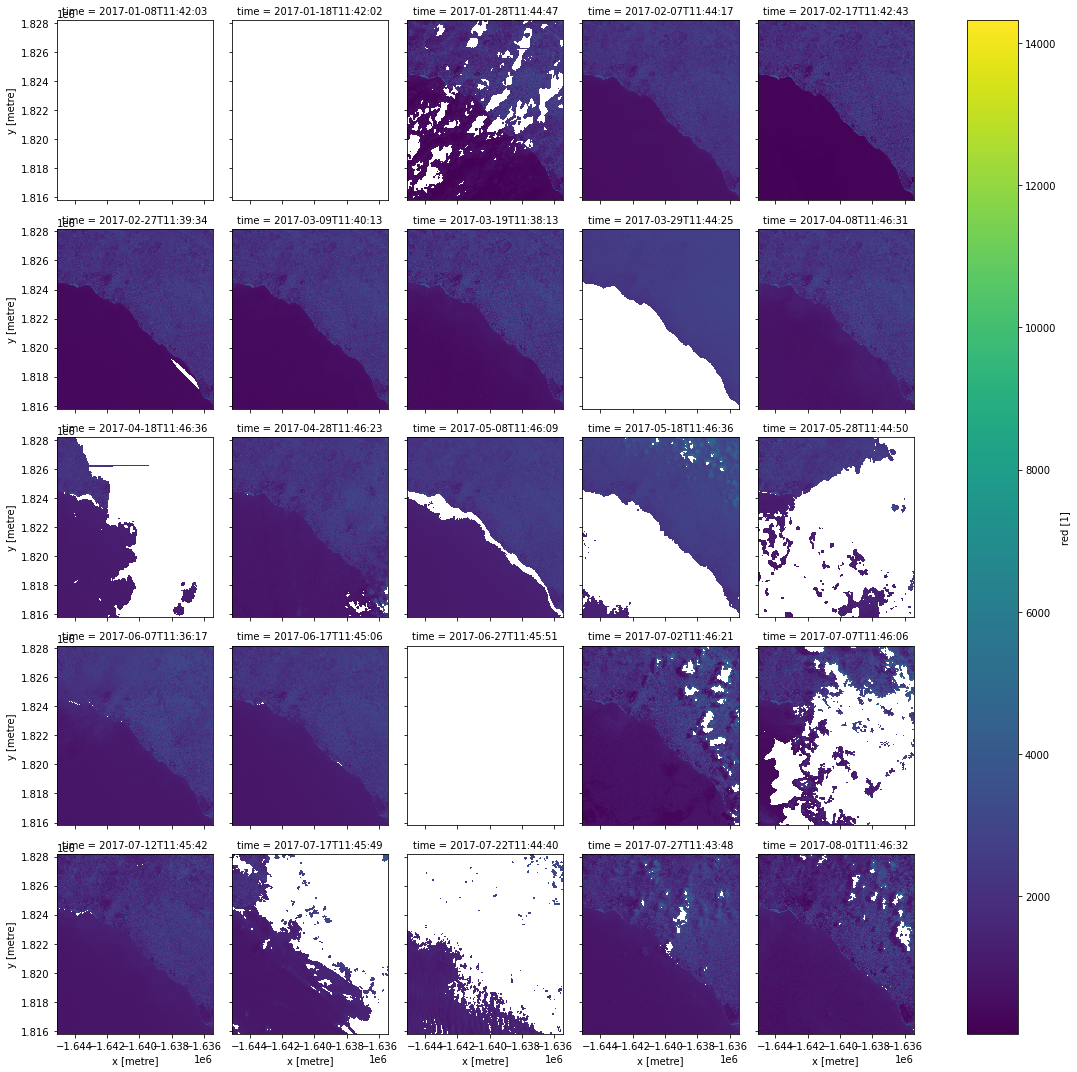

In [22]:
saly_dataset.isel(time= slice(0,25))['red'].plot(x="x", y="y", col="time", col_wrap=5)